# LAB 11 : Generative Adversarial Networks

Name : 

Roll Number :

References : 

  1. https://towardsdatascience.com/gans-from-scratch-8f5da17b3fb4

#**Problem 1** : Understanding and Training Vanilla GANs  

1. Consider MNIST Digit Dataset
2. Create a Generator and a Discriminator Network and train the network. Follow this article : https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
3. Explain briefly about your understanding of GANs

## Programming : 
  Please write a program to demonstrate the same

In [ ]:
## Write your code here
!pip install torchvision tensorboardx jupyter matplotlib numpy


In [ ]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets


LeCunn’s MNIST dataset, consisting of about 60,000 black and white images of handwritten digits, each with size 28x28 pixels²

Preprocessing : 

Specifically, the input values which range in between [0, 255] will be normalized between -1 and 1. This means the value 0 will be mapped to -1, the value 255 to 1, and similarly all values in between will get a value in the range [-1, 1].


In [ ]:


def mnist_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)



data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



### Discriminator



In [ ]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

###  Generative Network :



In [ ]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [ ]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()


we’ll use Adam as the optimization algorithm for both neural networks, with a learning rate of 0.0002

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002,  betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


Loss function : Binary Cross Entopy Loss (BCE Loss) as it resembles the log-loss for both the Generator and Discriminator

In [ ]:

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 50



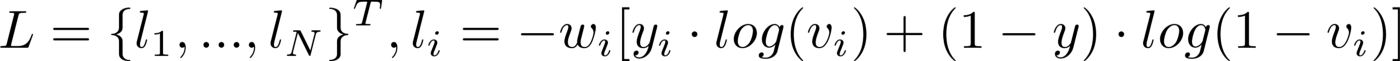
Binary Cross Entropy Log. Mean is calculated by computing sum(L) / N.
In this formula the values y are named targets, v are the inputs, and w are the weights. Since we don’t need the weight at all, it’ll be set to wᵢ=1 for all i.


Discriminator Loss:
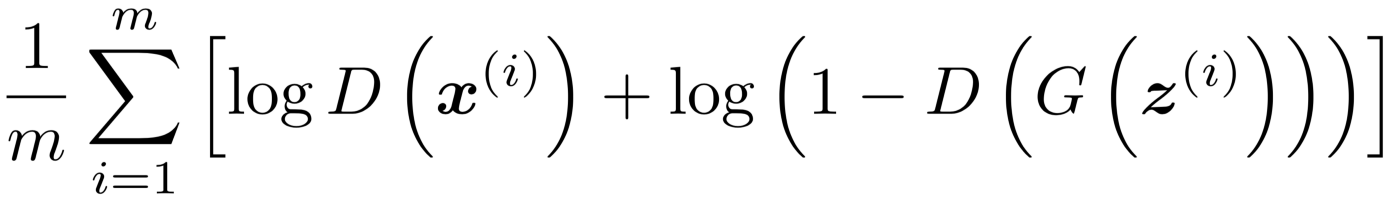

If we replace vᵢ = D(xᵢ) and yᵢ=1 ∀ i (for all i) in the BCE-Loss definition, we obtain the loss related to the real-images. Conversely if we set vᵢ = D(G(zᵢ)) and yᵢ=0 ∀ i, we obtain the loss related to the fake-images

Since maximizing a function is equivalent to minimizing it’s negative, and the BCE-Loss term has a minus sign, we don’t need to worry about the sign.


We can observe that the real-images targets are always ones, while the fake-images targets are zero, so it would be helpful to define the following functions:


In [ ]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data



By summing up these two discriminator losses we obtain the total mini-batch loss for the Discriminator. We will calculate the gradients separately, and then update them together.


In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

Generator Loss:
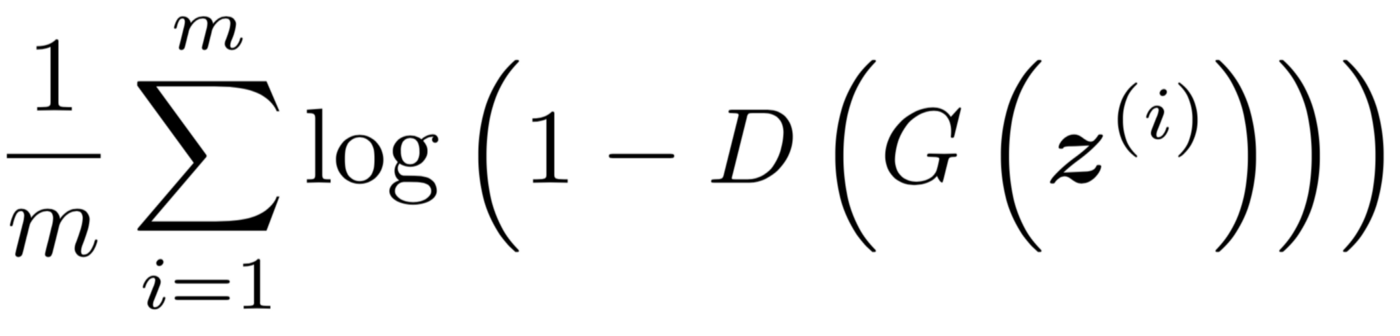

Rather than minimizing log(1- D(G(z))), training the Generator to maximize log D(G(z)) will provide much stronger gradients early in training. Both losses may be swapped interchangeably since they result in the same dynamics for the Generator and Discriminator.

Maximizing log D(G(z)) is equivalent to minimizing it’s negative and since the BCE-Loss definition has a minus sign, we don’t need to take care of the sign. Similarly to the Discriminator, if we set vᵢ = D(G(zᵢ)) and yᵢ=1 ∀ i, we obtain the desired loss to be minimized.


In [ ]:
!wget https://raw.githubusercontent.com/diegoalejogm/gans/master/utils.py

--2022-04-02 09:39:18--  https://raw.githubusercontent.com/diegoalejogm/gans/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4866 (4.8K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.75K  --.-KB/s    in 0s      

2022-04-02 09:39:19 (68.8 MB/s) - ‘utils.py’ saved [4866/4866]



In [ ]:
from utils import Logger
from IPython import display

In [ ]:

num_test_samples = 16
test_noise = noise(num_test_samples)


In [ ]:

logger = Logger(model_name='DCGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        print(real_data)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            # display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        # logger.save_models(generator, discriminator, epoch)



tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

KeyboardInterrupt: ignored